### Generate some statistics files

In [1]:
! pip install libsumo addict

Defaulting to user installation because normal site-packages is not writeable


In [48]:
import analysis.stats_utils_v2 as stats_utils
from analysis.viz_utils_v2 import visualizer
import os
from tqdm import tqdm
# change here
exp_repo = "/gpfs/accounts/henryliu_root/henryliu98/shared_data/safetest-nade/"
mode="ITE_autoware_universe_map_recalibrate_v3"
user = "haowei"
experiment_record_repo = f"{exp_repo}/{mode}/raw_data"
export_stat_dir = f"{exp_repo}/{mode}/{user}/processed_data"

# # test code
# experiment_record_repo = "output/test/raw_data"
# export_stat_dir = "output/test/processed_data"
# export_stat_dir = "."

if not os.path.exists(export_stat_dir):
    os.system(f"mkdir -p {export_stat_dir}")
    os.system(f"chmod 755 {export_stat_dir}")

In [49]:
stats_utils.export_to_csv(experiment_record_repo, export_stat_dir)
os.system(f"chmod -R 775 {export_stat_dir}")

100%|██████████| 4204/4204 [00:23<00:00, 175.50it/s]


info_error:  0


0

In [50]:
awk_cmd = """awk -F "[_/]" '{print $35}'""" + " check.txt | sort | uniq -cd"
print("count", "exp_id")
os.system(awk_cmd)

count exp_id


0

### Analyze

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#### Import statistics of each experiment

In [52]:
exp_stats_info = pd.read_csv(f"{export_stat_dir}/stats.tsv", sep='\t')
exp_stats_info.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v3_94_1,1395.0,NaN,NaN,-0.074517,704,NaN,-1.0,NaN,NaN,56152.238751,2630.873098,NaN,NaN,NaN,None,-10.0,NaN
1,ITE_autoware_universe_map_recalibrate_v3_94_2,1284.0,NaN,NaN,3.190742,978,NaN,-1.0,NaN,NaN,61463.358453,4929.809077,NaN,NaN,NaN,None,-10.0,NaN
2,ITE_autoware_universe_map_recalibrate_v3_94_3,1253.0,NaN,NaN,-0.151924,1277,NaN,-1.0,NaN,NaN,63380.135896,1238.247487,NaN,NaN,NaN,None,-10.0,NaN
3,ITE_autoware_universe_map_recalibrate_v3_94_4,1477.0,NaN,NaN,-0.103876,1039,NaN,-1.0,NaN,NaN,60717.899358,1998.499454,NaN,NaN,NaN,None,-10.0,NaN
4,ITE_autoware_universe_map_recalibrate_v3_94_5,1438.0,NaN,NaN,-0.084429,680,NaN,-1.0,NaN,NaN,51694.150335,3781.486380,NaN,NaN,NaN,None,-10.0,NaN


In [53]:
# exp_stats_info_old = pd.read_csv(f"{export_stat_dir}/stats-old.tsv", sep='\t')
# b = exp_stats_info_old[~exp_stats_info_old["neg_reason"].isna()]

# cnt = 0
# for name in a["name"]:
#     location = a[a["name"] == name]["location_type"].values[0]
#     collision_a = a[a["name"] == name]["collision_type"].values[0]
#     collision_b = b[b["name"] == name]["collision_type"].values[0]
#     if collision_a != collision_b and location == "intersection":
#         print(name, collision_a, collision_b)
#         cnt += 1
    
# print(cnt)

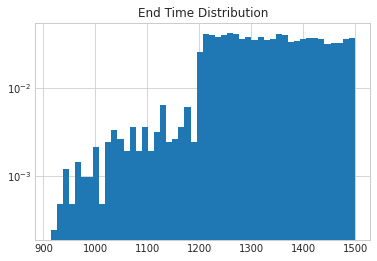

In [54]:
# draw the end time distribution
# exp_stats_info["end_time"].hist(bins=100)
num_experiments = len(exp_stats_info)
plt.hist(exp_stats_info["end_time"], weights=np.ones(num_experiments)/num_experiments, bins=50)
plt.yscale("log")
plt.title("End Time Distribution")
plt.savefig(f"{export_stat_dir}/end_time.png")

**Filter the experiments with time difference between negligence and collision larger than 3s**

In [55]:
warm_up_time = 900
estimated_end_time = warm_up_time + 300

has_collision = (exp_stats_info['end_time'] < estimated_end_time) & (exp_stats_info['end_time'] >= warm_up_time)
collision_df = exp_stats_info[has_collision]

has_collision_in_warmup = (exp_stats_info['end_time'] <= warm_up_time)
warmup_collision_df = exp_stats_info[has_collision_in_warmup]

print("Collision numbers:", len(collision_df), "Warmup collisions:", len(warmup_collision_df)) # the number of collisions 

Collision numbers: 239 Warmup collisions: 0


**See the list of files with time difference between negligence and collision larger than 3s**

### See the collisions

In [56]:
collision_df.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
10,ITE_autoware_universe_map_recalibrate_v3_94_11,1077.6,BV_13.8,BV_10.13,3.293805,109,BV_10.13,3.0,Lead,intersection_headon,1994.909040,137.552984,:NODE_10_5_0,head_on,intersection,126.54403840312642,-1.000000,8.815930
22,ITE_autoware_universe_map_recalibrate_v3_83_1,1171.3,BV_1.14,BV_5.8,2.793053,242,BV_1.14,0.7,LeftFoll,intersection_cutin,34199.190297,1893.052594,EG_17_23_1_1,angle,intersection,27.86621267723649,-2.195792,2.183411
50,ITE_autoware_universe_map_recalibrate_v3_102_9,1124.6,BV_8.79,BV_21.78,3.197557,1272,BV_8.79,0.6,LeftFoll,highway_cutin,47176.566086,2918.165622,EG_1_3_1_1,sideswipe,freeway_1,19.009503275854513,-0.407521,2.240695
131,ITE_autoware_universe_map_recalibrate_v3_4_16,980.0,BV_22.9,BV_22.10,3.272025,147,BV_22.10,1.7,Lead,intersection_rearend,11366.608941,1077.469727,EG_14_2_1_0,rear_end,intersection,0.0011246703347325138,-0.032409,5.111057
139,ITE_autoware_universe_map_recalibrate_v3_4_24,1168.7,BV_16.14,BV_7.11,-0.060825,621,BV_7.11,-1.0,NaN,NaN,28219.605711,710.072892,:NODE_18_10_0,angle,intersection,119.70801586280572,-1.000000,4.929979


In [57]:
all_maneuvers = exp_stats_info["maneuver_challenge"].sum()
all_time = (exp_stats_info["end_time"] - 900).sum()
all_routes = exp_stats_info["route_length"].sum()
mile_to_m = 1609.344
no_negligence_collision_related = collision_df['neg_time_diff'] < 0
power_importance_weight = np.power(10, - exp_stats_info['importance'])
collide_importance_weight = power_importance_weight[(power_importance_weight < 1) & has_collision]
importance_all = collide_importance_weight.sum()
num_experiments = len(exp_stats_info)
num_collisions = len(collision_df)
no_related_negligence_collision = collision_df[no_negligence_collision_related]

print(f"Number of experiments: {num_experiments}")
print(f"Number of collision: {num_collisions}")
print(f"Collisions with weight less than 1: {len(collide_importance_weight)}")
print(f"Importance summation: {importance_all}")
print(f"Max weight: {collide_importance_weight.max()}, Min weight: {collide_importance_weight.min()}")
print(f"raw collision rate: {num_collisions / num_experiments}")
print(f"adjusted collision rate (importance): {importance_all/num_experiments}")
print(f"Collision due to traffic light ignorance: {len(collision_df[collision_df['neg_reason'] == 'TFL'])}")
print(f"Overall maneuvers: {all_maneuvers}")

print(f"Collision without negligence: {len(no_related_negligence_collision)}")
print(f"Maximum time between collision and negligence: {collision_df['neg_time_diff'].max():.2f} s")

print()
print(f"Overall time: {all_time:.2f} s")
print(f"Maneuvers per second: {all_maneuvers / all_time}")
print(f"Overall route length: {all_routes:.2f} m")
print(f"m/s: {all_routes/all_time}")
print(f"Overall route length: {all_routes/mile_to_m} mile")
print(f"mile/s: {all_routes/mile_to_m/all_time} mile/s")
print(f"Crash per mile: {importance_all/all_routes*mile_to_m} crash/mile")

Number of experiments: 4204
Number of collision: 239
Collisions with weight less than 1: 224
Importance summation: 0.2670982978723292
Max weight: 0.010049213178125434, Min weight: 2.6406370750353435e-07
raw collision rate: 0.05685061845861085
adjusted collision rate (importance): 6.353432394679572e-05
Collision due to traffic light ignorance: 19
Overall maneuvers: 3646451
Collision without negligence: 16
Maximum time between collision and negligence: 4.10 s

Overall time: 1808978.40 s
Maneuvers per second: 2.0157515424175325
Overall route length: 235598317.61 m
m/s: 130.23832546261048
Overall route length: 146394.00750494134 mile
mile/s: 0.0809263435676962 mile/s
Crash per mile: 1.8245166070975522e-06 crash/mile


In [58]:
exp_stats_info.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v3_94_1,1395.0,NaN,NaN,-0.074517,704,NaN,-1.0,NaN,NaN,56152.238751,2630.873098,NaN,NaN,NaN,None,-10.0,NaN
1,ITE_autoware_universe_map_recalibrate_v3_94_2,1284.0,NaN,NaN,3.190742,978,NaN,-1.0,NaN,NaN,61463.358453,4929.809077,NaN,NaN,NaN,None,-10.0,NaN
2,ITE_autoware_universe_map_recalibrate_v3_94_3,1253.0,NaN,NaN,-0.151924,1277,NaN,-1.0,NaN,NaN,63380.135896,1238.247487,NaN,NaN,NaN,None,-10.0,NaN
3,ITE_autoware_universe_map_recalibrate_v3_94_4,1477.0,NaN,NaN,-0.103876,1039,NaN,-1.0,NaN,NaN,60717.899358,1998.499454,NaN,NaN,NaN,None,-10.0,NaN
4,ITE_autoware_universe_map_recalibrate_v3_94_5,1438.0,NaN,NaN,-0.084429,680,NaN,-1.0,NaN,NaN,51694.150335,3781.486380,NaN,NaN,NaN,None,-10.0,NaN


In [59]:
a = exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < 1200)]
a

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
139,ITE_autoware_universe_map_recalibrate_v3_4_24,1168.7,BV_16.14,BV_7.11,-0.060825,621,BV_7.11,-1.0,NaN,NaN,28219.605711,710.072892,:NODE_18_10_0,angle,intersection,119.70801586280572,-1.000000,4.929979
150,ITE_autoware_universe_map_recalibrate_v3_28_7,1093.9,BV_17.49,BV_8.57,-0.012364,182,BV_8.57,-1.0,NaN,NaN,6785.973794,395.853681,:nd_34_1_6_1_0,sideswipe,roundabout_1,16.186057015334825,3.280000,1.372196
511,ITE_autoware_universe_map_recalibrate_v3_134_5,1080.9,BV_16.17,BV_7.10,-0.017298,280,BV_7.10,-1.0,NaN,NaN,8162.922576,260.953496,:NODE_18_10_0,angle,intersection,119.6223849983578,3.280000,4.476589
706,ITE_autoware_universe_map_recalibrate_v3_103_4,992.8,BV_16.10,BV_7.10,-0.012940,161,BV_7.10,-1.0,NaN,NaN,17503.566295,1235.777521,:NODE_18_10_0,head_on,intersection,120.77728530068163,3.280000,5.513592
1191,ITE_autoware_universe_map_recalibrate_v3_26_21,992.8,BV_16.12,BV_7.6,-0.010298,94,BV_7.6,-1.0,NaN,NaN,12617.706331,1109.128927,:NODE_18_10_0,head_on,intersection,120.83749668393989,3.280000,5.215148
1274,ITE_autoware_universe_map_recalibrate_v3_204_10,1014.8,BV_19.16,BV_19.17,-0.034453,288,BV_19.17,-1.0,NaN,NaN,14854.157373,1370.390777,EG_16_45_1_1,angle,roundabout_2,65.5640899590506,-1.821002,2.194594
1916,ITE_autoware_universe_map_recalibrate_v3_122_13,1149.3,BV_1.12,BV_22.11,-0.013766,106,BV_22.11,-1.0,NaN,NaN,15772.084153,1429.905887,:NODE_18_8_0,angle,intersection,142.80050175918933,-1.000000,8.777652
2003,ITE_autoware_universe_map_recalibrate_v3_196_12,1132.5,BV_8.78,BV_21.58,-0.044486,407,BV_21.58,-1.0,NaN,NaN,33269.586876,796.636476,:nd_34_1_6_0_0,rear_end,roundabout_1,32.486376054820425,-1.000000,3.756615
2054,ITE_autoware_universe_map_recalibrate_v3_71_12,1165.5,BV_16.11,BV_7.11,-0.032638,334,BV_7.11,-1.0,NaN,NaN,25253.506475,1088.358731,:NODE_18_10_0,angle,intersection,119.33850035810315,3.280000,5.221357
2069,ITE_autoware_universe_map_recalibrate_v3_205_4,1028.5,BV_8.50,BV_21.40,-0.039715,347,BV_21.40,-1.0,NaN,NaN,20118.968009,1278.102166,:nd_34_1_6_0_0,rear_end,roundabout_1,25.980303465321526,3.280000,2.223784


#### BV_22 Collision

In [60]:
is_veh_1_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_1"])))
is_veh_2_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_2"])))
has_bv_22 = is_veh_1_bv_22 | is_veh_2_bv_22
bv_22_collision_df = collision_df[has_bv_22]

total_bv_22_distance = exp_stats_info["bv_22_route_length"].sum()

num_bv_22_expr = np.sum(has_bv_22)
bv_22_collision_is_large_1 = bv_22_collision_df["importance"] < 0
power_bv_22_weight = np.power(10, -bv_22_collision_df["importance"])[~bv_22_collision_is_large_1]
bv_22_importance = np.sum(power_bv_22_weight)

print("Number of bv_22 collision:", num_bv_22_expr)
print("Total bv_22 distance:", total_bv_22_distance)
print("Number of bv_22 collision importance > 1:", np.sum(bv_22_collision_is_large_1))
print("Raw collision rate:", num_bv_22_expr / num_experiments)
print("Collision rate:", bv_22_importance / num_experiments)
print("Collision rate (weighted):", bv_22_importance / total_bv_22_distance * mile_to_m)

Number of bv_22 collision: 23
Total bv_22 distance: 11865585.87089884
Number of bv_22 collision importance > 1: 1
Raw collision rate: 0.005470980019029496
Collision rate: 4.772555661509856e-06
Collision rate (weighted): 2.7212811170359113e-06


### Crash Distribution (with negligence)

In [61]:
exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < 1200) & (exp_stats_info["neg_time_diff"]  > 0)]

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity


### Load file that show the relationship between lane and experiment

**See the collision number in each experiment**

In [62]:
exp_stats_info.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v3_94_1,1395.0,NaN,NaN,-0.074517,704,NaN,-1.0,NaN,NaN,56152.238751,2630.873098,NaN,NaN,NaN,None,-10.0,NaN
1,ITE_autoware_universe_map_recalibrate_v3_94_2,1284.0,NaN,NaN,3.190742,978,NaN,-1.0,NaN,NaN,61463.358453,4929.809077,NaN,NaN,NaN,None,-10.0,NaN
2,ITE_autoware_universe_map_recalibrate_v3_94_3,1253.0,NaN,NaN,-0.151924,1277,NaN,-1.0,NaN,NaN,63380.135896,1238.247487,NaN,NaN,NaN,None,-10.0,NaN
3,ITE_autoware_universe_map_recalibrate_v3_94_4,1477.0,NaN,NaN,-0.103876,1039,NaN,-1.0,NaN,NaN,60717.899358,1998.499454,NaN,NaN,NaN,None,-10.0,NaN
4,ITE_autoware_universe_map_recalibrate_v3_94_5,1438.0,NaN,NaN,-0.084429,680,NaN,-1.0,NaN,NaN,51694.150335,3781.486380,NaN,NaN,NaN,None,-10.0,NaN


In [63]:
# collision: negligence-caused 和 no negligence caused (SUMO)
# 每个种类做collision node的分布
neg_caused_collision = exp_stats_info[exp_stats_info["neg_time_diff"] >= 0 & has_collision] # weight < 1 collisions
no_neg_realated_collision = exp_stats_info[(exp_stats_info["neg_time_diff"] < 0) & has_collision]
print(len(neg_caused_collision), len(no_neg_realated_collision))

435 16


Negligence caused distribution

In [64]:
neg_caused_collision["lane_id"].value_counts()

EG_25_2_1_0     39
EG_16_23_1_1    33
EG_1_3_1_1      31
EG_1_3_1_0      26
EG_17_1_1_0     24
                ..
EG_17_23_1_0     1
:NODE_13_0_0     1
:NODE_22_3_0     1
:NODE_18_8_0     1
EG_21_1_5_0      1
Name: lane_id, Length: 79, dtype: int64

No negligence caused distribution

In [65]:
print(no_neg_realated_collision["lane_id"].value_counts())
print(len(no_neg_realated_collision))

:NODE_18_10_0     8
:nd_34_1_6_0_0    3
:NODE_11_15_0     2
:nd_34_1_6_1_0    1
EG_16_45_1_1      1
:NODE_18_8_0      1
Name: lane_id, dtype: int64
16


### Crash Distribution (with negligence)

In [66]:
neg_caused_collision.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
10,ITE_autoware_universe_map_recalibrate_v3_94_11,1077.6,BV_13.8,BV_10.13,3.293805,109,BV_10.13,3.0,Lead,intersection_headon,1994.909040,137.552984,:NODE_10_5_0,head_on,intersection,126.54403840312642,-1.000000,8.815930
22,ITE_autoware_universe_map_recalibrate_v3_83_1,1171.3,BV_1.14,BV_5.8,2.793053,242,BV_1.14,0.7,LeftFoll,intersection_cutin,34199.190297,1893.052594,EG_17_23_1_1,angle,intersection,27.86621267723649,-2.195792,2.183411
28,ITE_autoware_universe_map_recalibrate_v3_83_7,1234.0,BV_21.54,BV_17.59,3.232988,572,BV_21.54,0.6,RightFoll,highway_cutin,31667.282251,789.617236,EG_1_1_1_0,sideswipe,freeway_2,17.173287787289325,-1.102316,2.839231
42,ITE_autoware_universe_map_recalibrate_v3_102_1,1208.6,BV_23.34,BV_2.32,3.230359,639,BV_2.32,2.3,Lead,intersection_rearend,49345.218804,1962.170479,:NODE_25_1_0,rear_end,intersection,31.658434319231027,0.329982,5.400785
50,ITE_autoware_universe_map_recalibrate_v3_102_9,1124.6,BV_8.79,BV_21.78,3.197557,1272,BV_8.79,0.6,LeftFoll,highway_cutin,47176.566086,2918.165622,EG_1_3_1_1,sideswipe,freeway_1,19.009503275854513,-0.407521,2.240695


In [67]:
def crash_distribution(neg_caused_collision, feat_name):
    crash_type_dist = neg_caused_collision.groupby(["location", feat_name], as_index=False).agg(
        {
            "name": "count",
            "exp_importance": "sum"
        }
    )

    crash_type_dist["collision_rate"] = crash_type_dist["name"] / num_experiments
    crash_type_dist["importance_rate"] = crash_type_dist["exp_importance"] / num_experiments

    crash_type_dist.rename(columns={"name": "count"}, inplace=True)
    return crash_type_dist

In [68]:
neg_caused_collision = neg_caused_collision.copy()
neg_caused_collision["exp_importance"] = np.power(10, -neg_caused_collision["importance"])

# ! should be commmented later
neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0

get_type_func = lambda x: x.split("_")[0] if x is not np.nan else "None"
neg_caused_collision["location"] = list(map(get_type_func, neg_caused_collision["location_type"]))
neg_caused_collision["collision"] = list(map(get_type_func, neg_caused_collision["collision_type"]))


crash_type_dist = crash_distribution(neg_caused_collision, "collision")
crash_type_dist

/tmp/ipykernel_145825/1315232982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,6,0.003011,0.001427,7.162452e-07
1,freeway,rear,10,0.122530,0.002379,2.914607e-05
2,freeway,sideswipe,60,0.030103,0.014272,7.160667e-06
3,intersection,angle,57,0.149984,0.013559,3.567647e-05
4,intersection,head,27,0.031116,0.006422,7.401417e-06
5,intersection,rear,197,0.116925,0.046860,2.781288e-05
6,intersection,sideswipe,42,0.068421,0.009990,1.627517e-05
7,roundabout,angle,17,0.009128,0.004044,2.171255e-06
8,roundabout,rear,9,0.004549,0.002141,1.082010e-06
9,roundabout,sideswipe,10,0.005789,0.002379,1.376994e-06


location
freeway         0.582724
intersection    1.371950
roundabout      0.072878
Name: exp_importance, dtype: float64


Text(0.5, 1.0, 'ground truth')

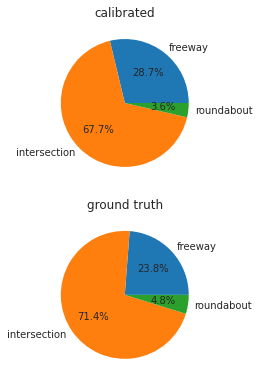

In [69]:
location_distribution = neg_caused_collision.groupby("location").sum()/importance_all
proportion = location_distribution["exp_importance"]
print(proportion)

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.pie(proportion, labels=proportion.index, autopct='%1.1f%%')
# plt.bar(proportion.index, values=proportion)
plt.title("calibrated")
plt.subplot(3, 1, 2)
true_dist = np.array([1525, 4581, 307]) / (1525 + 4581 + 307)
plt.pie(true_dist, labels=proportion.index, autopct='%1.1f%%')
# plt.bar(proportion.index, values=true_dist)
plt.title("ground truth")

In [70]:
def pie_chart_plot(df, mode, feat_name):
    mark = df["location"] == mode
    labels = df[mark][feat_name]
    values = df[mark]["importance_rate"]
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    # plt.bar(labels, values)
    plt.title(f'{mode}')
    # plt.legend(labels)

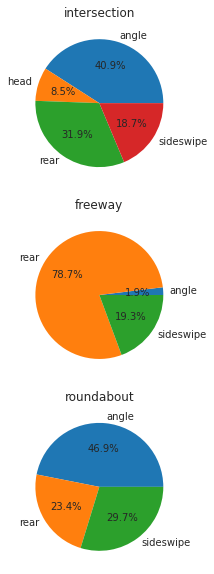

In [71]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/pie_chart.png")

In [72]:
len(neg_caused_collision)

435

#### Negligence reason

In [73]:
neg_reason_crash_dist = crash_distribution(neg_caused_collision, "neg_reason")
neg_reason_crash_dist

,location,neg_reason,count,exp_importance,collision_rate,importance_rate
0,freeway,Lead,10,0.122530,0.002379,0.000029
1,freeway,LeftFoll,31,0.015324,0.007374,0.000004
2,freeway,RightFoll,35,0.017790,0.008325,0.000004
3,intersection,Lead,228,0.120430,0.054234,0.000029
4,intersection,LeftFoll,52,0.081199,0.012369,0.000019
5,intersection,RightFoll,16,0.024435,0.003806,0.000006
6,intersection,TFL,27,0.140382,0.006422,0.000033
7,roundabout,Lead,11,0.005071,0.002617,0.000001
8,roundabout,LeftFoll,9,0.005247,0.002141,0.000001
9,roundabout,RightFoll,16,0.009148,0.003806,0.000002


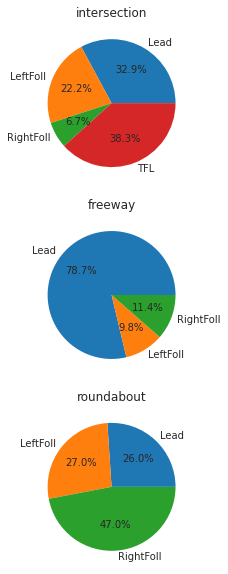

In [74]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(neg_reason_crash_dist, "intersection", "neg_reason")
plt.subplot(3, 1, 2)
pie_chart_plot(neg_reason_crash_dist, "freeway", "neg_reason")
plt.subplot(3, 1, 3)
pie_chart_plot(neg_reason_crash_dist, "roundabout", "neg_reason")
plt.savefig(f"{export_stat_dir}/neg_reason_pie_chart.png")

#### BV 22 Negligence Caused

In [75]:
is_veh_1_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), neg_caused_collision["crash_veh_1"])))
is_veh_2_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), neg_caused_collision["crash_veh_2"])))
has_bv_22 = is_veh_1_bv_22 | is_veh_2_bv_22
bv_22_neg_caused_collision = neg_caused_collision[has_bv_22]



bv_22_crash_type_dist = crash_distribution(bv_22_neg_caused_collision, "collision")
bv_22_crash_type_dist

,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,rear,1,0.012158,0.000238,2.892098e-06
1,freeway,sideswipe,1,0.000512,0.000238,1.217141e-07
2,intersection,angle,4,0.009519,0.000951,2.264208e-06
3,intersection,rear,17,0.014452,0.004044,3.437776e-06
4,intersection,sideswipe,10,0.017954,0.002379,4.270777e-06
5,roundabout,angle,1,0.000599,0.000238,1.425413e-07
6,roundabout,rear,3,0.001694,0.000714,4.030446e-07


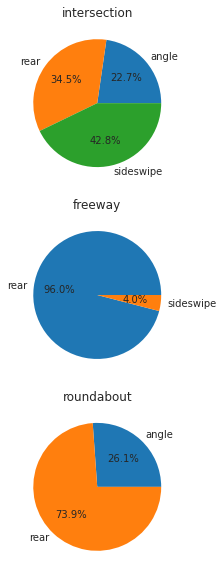

In [76]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(bv_22_crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(bv_22_crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(bv_22_crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/bv_22_pie_chart.png")

##### EG happened collision intersection&angle

In [77]:
eg_collision = list(neg_caused_collision["lane_id"])
eg_collision_angle_df = neg_caused_collision[((neg_caused_collision["collision"] == "angle") | (neg_caused_collision["collision"] == "sideswipe")) & (neg_caused_collision["location"] == "freeway")]
# print(neg_caused_collision["relative_heading"])
# print(len(neg_caused_collision["relative_heading"]))

heading_float_list = [float(heading) for heading in eg_collision_angle_df["relative_heading"] if heading != 'None']
heading_float_list = np.array(heading_float_list)
print(len(heading_float_list))

66


In [78]:
eg_collision_angle_df = eg_collision_angle_df.sort_values(by="relative_heading")
eg_collision_angle_df["exp_cum"] = eg_collision_angle_df["exp_importance"].cumsum() / eg_collision_angle_df["exp_importance"].sum()
eg_collision_angle_df[eg_collision_angle_df["exp_cum"] < 28.08/(28.08+2.52)]

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,...,lane_id,collision_type,location_type,relative_heading,distance,collision_severity,exp_importance,location,collision,exp_cum
1173,ITE_autoware_universe_map_recalibrate_v3_26_3,1380.1,BV_17.76,BV_17.75,3.202116,887,BV_17.76,0.6,LeftFoll,highway_cutin,...,EG_1_1_1_1,sideswipe,freeway_2,16.97580486025487,-1.446800,2.908863,6.278905e-04,freeway,sideswipe,0.018961
3088,ITE_autoware_universe_map_recalibrate_v3_52_2,1095.3,BV_14.13,BV_17.63,3.207180,438,BV_14.13,0.6,LeftFoll,highway_cutin,...,EG_1_3_1_1,sideswipe,freeway_1,17.008694394652878,-0.822942,3.334866,6.206114e-04,freeway,sideswipe,0.037703
2156,ITE_autoware_universe_map_recalibrate_v3_62_4,1066.7,BV_21.40,BV_17.47,3.288304,172,BV_21.40,0.6,RightFoll,highway_cutin,...,EG_1_1_1_0,sideswipe,freeway_2,17.13629445340797,-0.013682,2.597932,5.148687e-04,freeway,sideswipe,0.053251
28,ITE_autoware_universe_map_recalibrate_v3_83_7,1234.0,BV_21.54,BV_17.59,3.232988,572,BV_21.54,0.6,RightFoll,highway_cutin,...,EG_1_1_1_0,sideswipe,freeway_2,17.173287787289325,-1.102316,2.839231,5.848057e-04,freeway,sideswipe,0.070911
2413,ITE_autoware_universe_map_recalibrate_v3_157_7,1230.2,BV_21.50,BV_8.65,6.410221,950,BV_21.50,0.6,RightFoll,highway_cutin,...,EG_1_3_1_0,sideswipe,freeway_1,17.225629436651317,-0.860980,2.811340,3.888471e-07,freeway,sideswipe,0.070922
746,ITE_autoware_universe_map_recalibrate_v3_153_12,1226.9,BV_21.51,BV_17.64,3.179564,1142,BV_21.51,0.6,RightFoll,highway_cutin,...,EG_1_1_1_0,sideswipe,freeway_2,17.505611998566906,-0.440608,2.785824,6.613578e-04,freeway,sideswipe,0.090894
2753,ITE_autoware_universe_map_recalibrate_v3_135_11,1102.3,BV_17.50,BV_17.49,3.281232,171,BV_17.50,0.6,LeftFoll,highway_cutin,...,EG_1_1_1_1,sideswipe,freeway_2,17.547755482336783,-0.251000,2.816012,5.233214e-04,freeway,sideswipe,0.106698
2285,ITE_autoware_universe_map_recalibrate_v3_64_1,1139.5,BV_17.51,BV_21.40,3.280551,137,BV_17.51,0.6,LeftFoll,highway_cutin,...,EG_1_3_1_1,sideswipe,freeway_1,17.58797216839332,-0.557689,3.701170,5.241416e-04,freeway,sideswipe,0.122526
3347,ITE_autoware_universe_map_recalibrate_v3_47_2,1288.5,BV_21.60,BV_8.77,3.233364,798,BV_21.60,0.6,RightFoll,highway_cutin,...,EG_1_3_1_0,sideswipe,freeway_1,17.712799791185716,-1.179158,2.820476,5.842996e-04,freeway,sideswipe,0.140171
2148,ITE_autoware_universe_map_recalibrate_v3_123_13,1183.1,BV_17.55,BV_13.9,3.240487,499,BV_17.55,0.6,RightFoll,highway_cutin,...,EG_1_1_1_0,sideswipe,freeway_2,17.725914857945554,-0.406971,2.797190,5.747946e-04,freeway,sideswipe,0.157528


0.09090909090909091


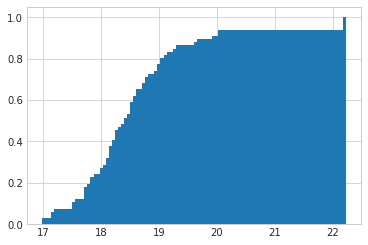

In [79]:
# # draw the histogram of the relative_heading of the collision in each location in neg_caused_collision
# grouped_neg_collision = neg_caused_collision["relative_heading"].groupby(neg_caused_collision["location"])
# for name, group_data in grouped_neg_collision:
#     plt.figure()
#     plt.hist(group_data, bins=50)
#     # plt.title(f"Collision Relative Heading Distribution in {name}")
# heading_flaot_list = np.clip(heading_flaot_list, 0, 30)
plt.figure()
plt.hist(heading_float_list, bins=100, density=True, cumulative=True)

print(np.sum(heading_float_list>20)/len(heading_float_list))

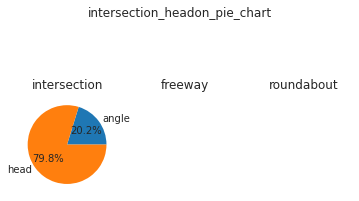

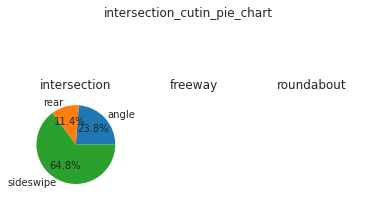

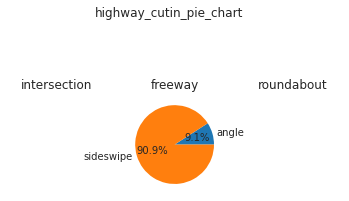

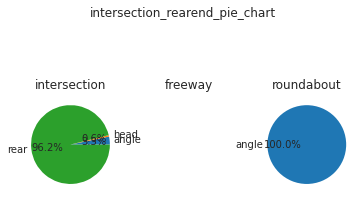

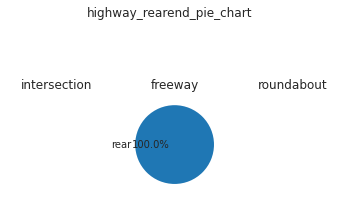

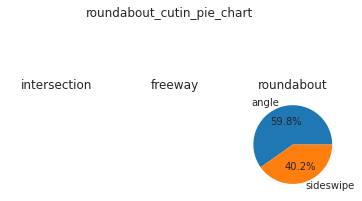

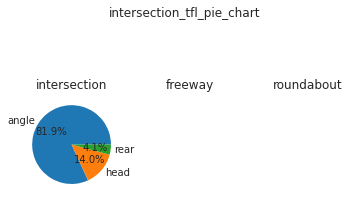

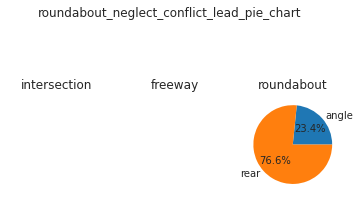

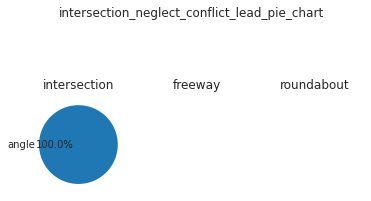

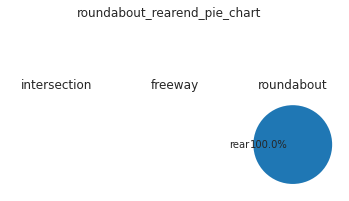

In [80]:
neg_uniq_infos = neg_caused_collision["neg_info"].unique()

neg_info_crash_dist = {}
for info in neg_uniq_infos:
    df = neg_caused_collision[neg_caused_collision["neg_info"] == info].copy()
    
    crash_type_dist = crash_distribution(df, "collision")
    neg_info_crash_dist[info] = crash_type_dist
    plt.figure()
    plt.subplot(1, 3, 1)
    pie_chart_plot(crash_type_dist, "intersection", "collision")
    plt.subplot(1, 3, 2)
    pie_chart_plot(crash_type_dist, "freeway", "collision")
    plt.subplot(1, 3, 3)
    pie_chart_plot(crash_type_dist, "roundabout", "collision")
    plt.suptitle(f"{info}_pie_chart")
    plt.savefig(f"{export_stat_dir}/{info}_pie_chart.png")

In [81]:
from IPython.display import display
for info, crash_dist in neg_info_crash_dist.items():
    print(info)
    display(crash_dist)

intersection_headon


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,5,0.002795,0.001189,6.648914e-07
1,intersection,head,22,0.011019,0.005233,2.620958e-06


intersection_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,18,0.025136,0.004282,0.000006
1,intersection,rear,8,0.012077,0.001903,0.000003
2,intersection,sideswipe,42,0.068421,0.009990,0.000016


highway_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,6,0.003011,0.001427,7.162452e-07
1,freeway,sideswipe,60,0.030103,0.014272,7.160667e-06


intersection_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,6,0.003353,0.001427,7.974997e-07
1,intersection,head,1,0.000612,0.000238,1.456897e-07
2,intersection,rear,188,0.099102,0.044719,2.357320e-05
3,roundabout,angle,1,0.000003,0.000238,6.640785e-10


highway_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,rear,10,0.12253,0.002379,0.000029


roundabout_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,angle,15,0.008606,0.003568,0.000002
1,roundabout,sideswipe,10,0.005789,0.002379,0.000001


intersection_tfl


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,20,0.113983,0.004757,0.000027
1,intersection,head,4,0.019485,0.000951,0.000005
2,intersection,rear,1,0.005747,0.000238,0.000001


roundabout_neglect_conflict_lead


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,angle,1,0.000519,0.000238,1.234912e-07
1,roundabout,rear,4,0.001701,0.000951,4.047062e-07


intersection_neglect_conflict_lead


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,8,0.004717,0.001903,0.000001


roundabout_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,rear,5,0.002847,0.001189,6.773039e-07


In [82]:
! pip install gurobipy
col_names = ["ia", "ih", "ir", "is", "ra", "rr", "rs", "fr", "fs", "fa"]

row_names = [
    "intersection_cutin", 
    "intersection_neglect_conflict_lead", 
    "intersection_rearend", 
    "intersection_tfl",
    "intersection_headon",
    "roundabout_cutin",
    "roundabout_neglect_conflict_lead",
    "roundabout_rearend",
    "highway_cutin",
    "highway_rearend"
]

translate_col = {col: i for i, col in enumerate(col_names)}
translate_row = {row: i for i, row in enumerate(row_names)}

A = np.zeros((len(translate_row), len(translate_col))).astype(int)
for row_mark in neg_info_crash_dist.keys():
    df = neg_info_crash_dist[row_mark]
    important_values = df["importance_rate"]
    col_marks = np.array(list(map(lambda x: x[1][0][0]+x[1][1][0], df.iterrows())))
    for col_mark, v in zip(col_marks, important_values):
        if col_mark in translate_col:
            A[translate_row[row_mark], translate_col[col_mark]] = v * 1e9
A = A.T

Defaulting to user installation because normal site-packages is not writeable


In [83]:
A[:4, 5:] = 0
A[4:, :5] = 0
A[:7, 8:] = 0
A[7:, :8] = 0

In [84]:
A

array([[ 5978,  1122,   797, 27113,   664,     0,     0,     0,     0,
            0],
       [    0,     0,   145,  4634,  2620,     0,     0,     0,     0,
            0],
       [ 2872,     0, 23573,  1366,     0,     0,     0,     0,     0,
            0],
       [16275,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,  2047,   123,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,   404,   677,     0,
            0],
       [    0,     0,     0,     0,     0,  1376,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
        29146],
       [    0,     0,     0,     0,     0,     0,     0,     0,  7160,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,   716,
            0]])

#### Calibration

In [85]:
import itertools
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# basic parameters
n = A.shape[1]
m = A.shape[0]
b = np.array([1839, 285, 1648, 808, 169, 53, 85, 1058, 428, 38])
all_miles = all_routes / mile_to_m
b = b / b.sum() * all_miles / num_experiments * 3e3

# Gurobi model
model = gp.Model()
model.reset()

# variable
x = model.addVars(range(n), lb=0.1)
t = model.addVars(range(m), lb=0)
upper = model.addVar(lb=1)
lower = model.addVar(lb=0)

# optimization goal
model.setObjective(sum(t[i] for i in range(m)) + 20 * upper + 200 * (1-lower), GRB.MINIMIZE)

# constraints
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] <= t[i] for i in range(m))
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] >= -t[i] for i in range(m))
model.addConstrs(x[i] <= upper for i in range(n))
model.addConstrs(x[i] >= lower for i in range(n))
model.update()

# solve the model
model.optimize()
if model.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", model.status)
    print("***** This is a problem. Model does not have an optimal solution")
    raise StopExecution
print(" ")
print("***** Solution:")
# x_solved = np.array([x[i].X for i in range(n)]).reshape(-1, 1)
# t_solved = np.array([t[i].X for i in range(m)]).reshape(-1, 1)
x_solved = [x[i].X for i in range(n)]
t_solved = [t[i].X for i in range(m)]
x_mark_solved = list(zip(translate_row, x_solved))
t_mark_solved = list(zip(translate_col, t_solved))
print("x =",  *x_mark_solved, sep="\n")
print("t =",  *t_mark_solved, sep="\n")
print("x upper bound = ", upper.X)
print("x upper bound = ", lower.X)
print("b =", b)

Discarded solution information
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6154 CPU @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 36 physical cores, 36 logical processors, using up to 32 threads

Optimize a model with 40 rows, 22 columns and 100 nonzeros
Model fingerprint: 0xb9f7da29
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [6e+02, 3e+04]
Presolve time: 0.01s
Presolved: 40 rows, 22 columns, 100 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0000000e+32   1.000000e+31   2.000000e+02      0s
      18    5.8510774e+02   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.02 seconds (0.00 work units)
Optimal objective  5.851077396e+02
 
***** Solution:
x =
('intersection_cutin', 0.808996110630546)
('intersection_neglect_conflict_lead', 1.6931859916074596)
('intersect

### Quick check

In [40]:
quick_check_exp = no_neg_realated_collision.groupby("lane_id").agg({
    "name": ["nunique", "first"],
    # "veh_1_route": set,
    # "veh_2_route": set,
    # "experiment": "first"
})
# quick_check_exp["veh_route"] = quick_check_exp[["veh_1_route", "veh_2_route"]].apply(lambda x: set(x[0]) | set(x[1]), axis=1)
quick_check_exp.sort_values(by=("name", "nunique"), ascending=False)

name                                              
               nunique                                         first
lane_id                                                             
:NODE_18_10_0       31   ITE_autoware_universe_map_recalibrate_327_5
:nd_34_1_6_0_0      15   ITE_autoware_universe_map_recalibrate_43_14
:NODE_18_17_0        9  ITE_autoware_universe_map_recalibrate_328_23
:nd_34_1_6_1_0       8   ITE_autoware_universe_map_recalibrate_72_27
:NODE_11_15_0        5   ITE_autoware_universe_map_recalibrate_141_5
EG_18_12_171_1       5    ITE_autoware_universe_map_recalibrate_5_22
EG_16_45_1_1         3    ITE_autoware_universe_map_recalibrate_69_4

0.02871435531383316 7.223033448528298e-10


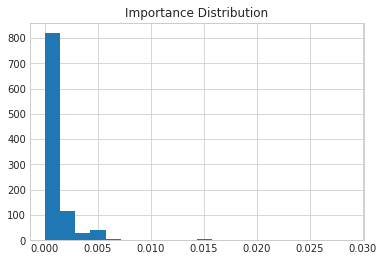

In [41]:
plt.hist(collide_importance_weight, bins=20)
plt.title("Importance Distribution")
plt.savefig(f'{export_stat_dir}/importance.png', dpi=300)
print(collide_importance_weight.max(), collide_importance_weight.min())

#### Export the checklist

In [42]:
# simple checklist
quick_check_list_path = f"{export_stat_dir}/quick_check_list.txt"
neg_caused_check_list_path = f"{export_stat_dir}/neg_caused_check_list.txt"
non_neg_check_list_path = f"{export_stat_dir}/non_neg_check_list.txt"

with open(quick_check_list_path, "w") as f:
    print(*set(quick_check_exp[("name", "first")].values), sep="\n", file=f)
with open(neg_caused_check_list_path, "w") as f:
    print(*set(neg_caused_collision["name"].values), sep="\n", file=f)
with open(non_neg_check_list_path, "w") as f:
    print(*set(no_neg_realated_collision["name"].values), sep="\n", file=f)

In [43]:
# ! pip install shapely

In [44]:
exp_stats_info

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_43_1,1228.0,NaN,NaN,-0.138588,1203,NaN,-1.0,NaN,NaN,62477.109805,3525.611964,NaN,NaN,NaN,None,-10.000000,NaN
1,ITE_autoware_universe_map_recalibrate_43_2,1302.0,NaN,NaN,-0.079461,714,NaN,-1.0,NaN,NaN,57448.336152,4669.144013,NaN,NaN,NaN,None,-10.000000,NaN
2,ITE_autoware_universe_map_recalibrate_43_3,1291.0,NaN,NaN,-0.113009,1235,NaN,-1.0,NaN,NaN,66404.538043,400.173821,NaN,NaN,NaN,None,-10.000000,NaN
3,ITE_autoware_universe_map_recalibrate_43_4,1478.0,NaN,NaN,2.468619,957,NaN,-1.0,NaN,NaN,63592.300424,2497.472657,NaN,NaN,NaN,None,-10.000000,NaN
4,ITE_autoware_universe_map_recalibrate_43_5,1286.0,NaN,NaN,-0.107113,780,NaN,-1.0,NaN,NaN,62893.668104,1056.951204,NaN,NaN,NaN,None,-10.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20844,ITE_autoware_universe_map_recalibrate_174_40,1412.0,NaN,NaN,3.144204,965,NaN,-1.0,NaN,NaN,67936.058153,4056.776624,NaN,NaN,NaN,None,-10.000000,NaN
20845,ITE_autoware_universe_map_recalibrate_174_41,1224.6,BV_16.20,BV_16.21,3.248702,358,BV_16.21,1.9,Lead,intersection_rearend,48694.576757,3112.168829,:NODE_18_10_0,rear_end,intersection,18.771320185726097,0.031298,7.312075
20846,ITE_autoware_universe_map_recalibrate_174_42,1310.0,NaN,NaN,-0.117569,1112,NaN,-1.0,NaN,NaN,62550.748278,3130.629523,NaN,NaN,NaN,None,-10.000000,NaN
20847,ITE_autoware_universe_map_recalibrate_174_43,1436.0,NaN,NaN,-0.095646,888,NaN,-1.0,NaN,NaN,57185.845068,2655.637894,NaN,NaN,NaN,None,-10.000000,NaN


### Generate videos in the check list

In [45]:
exp_stats_info["location"] = list(map(get_type_func, exp_stats_info["location_type"]))
exp_stats_info["collision"] = list(map(get_type_func, exp_stats_info["collision_type"]))

In [46]:
def get_location_collision_type(exp_id, exp_stats_info):
    mark = exp_stats_info["name"] == exp_id
    location_type = exp_stats_info[mark]["location"].values[0]
    collision_type = exp_stats_info[mark]["collision"].values[0]
    return location_type, collision_type

def export_videos(export_path, file_name, map_location="."):
    if not os.path.exists(export_path):
        os.system(f"mkdir -p {export_path}")
        os.system(f"chmod 755 {export_path}")
    with open(file_name) as f:
        for line in tqdm(f.readlines()): 
            exp_id = line.strip()
            path_name = os.path.join(experiment_record_repo, exp_id)
            if os.path.isdir(path_name):
                location_type, collision_type = get_location_collision_type(exp_id, exp_stats_info)
                if location_type == "None" or collision_type == "None":
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, "None"))
                else:
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, f"{location_type}/{collision_type}"))

In [47]:
# 生成三个文件夹: simple(typical) non-negligence-caused negligence-caused 
export_path = f"{exp_repo}/{mode}/{user}/videos"
file_name = f"{export_stat_dir}/check_list.txt"

# quick check
# export_videos(f"{export_path}/quick_check", "check.txt")

export_videos(f"{export_path}/non_neg_check", non_neg_check_list_path)
# export_videos(f"{export_path}/neg_caused_check", neg_caused_check_list_path)

  0%|          | 0/76 [00:00<?, ?it/s]

/gpfs/accounts/henryliu_root/henryliu98/shared_data/safetest-nade/ITE_autoware_universe_map_recalibrate/raw_data/final_state/ITE_autoware_universe_map_recalibrate_98_final_state.json


  0%|          | 0/76 [00:17<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: './maps/Mcity/mcity.net.xml'

### See README-viz.md for visualization

In [ ]:
exp_stats_info[(exp_stats_info["location"] == "roundabout") & (exp_stats_info["lane_id"] == ":NODE_21_0_0") & (exp_stats_info["neg_info"] == "roundabout_neglect_conflict_lead")]["name"].values

In [ ]:
exp_stats_info[(exp_stats_info["location"] == "roundabout")]["lane_id"].unique()